In [1]:
%pylab inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table,Column
import os
import warnings
import requests

mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True);

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../data/{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [3]:
#Load Data!
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/ev27r4dcti5iruy/ferengi_data.fits?dl=1")
data = Table.read(ferengi_filename) 

In [4]:
#Defining surface brightness bins
yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),10)

In [5]:
#Pick out unique galaxies
galaxies = set(data['sdss_id'])

In [164]:
#simulated redshifts of ferengi data:
reds=[.3,.4,.5,.6,.7,.8,.9,1]
#Defining lists of p_features at high and low (z=0.3) redshifts at given SB and redshifts. 
scatter_dct={}
for z in reds:
    for edge in yedges:
        scatter_dct[z,edge,'hi']=[]
        scatter_dct[z,edge,'lo']=[]
        scatter_dct[z,edge,'subj_id']=[]

In [165]:
#In each SB range and simulated redshift, make a list of p_features at that redshift and p_features at z=0.3   
for i,g in enumerate(galaxies):
    this_gal=(data['sdss_id']==g)
    evos = list(set(data[this_gal]['sim_evolution']))
    if 0 in evos:
        evos.remove(0) #remove this line if including 0 evolution data
    for e in evos:
        this_evo=(data[this_gal]['sim_evolution']==e)
        if len(set(data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(data[this_gal][this_evo]['sim_redshift']==.3)
            p_features_at_3 = data[this_gal][this_evo][p_at_3]['p_features'][0]#value of p_bar at redshift 0.3
            for row in data[this_gal][this_evo]:
                for y in range(0,len(yedges)-1):
                    for j,hi_z in enumerate(reds):
                        if round(row['sim_redshift'],2)==hi_z and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1]: #now look at high redshift data
                            scatter_dct[hi_z,yedges[y],'hi'].append(row['p_features']) # slap p_features in high list 
                            scatter_dct[hi_z,yedges[y],'lo'].append(p_features_at_3) # put z=0.3 value in low list 
                            scatter_dct[hi_z,yedges[y],'subj_id'].append(row['subject_id'])
                            
         

In [ ]:
def derivative_of_poly(x_list,fit_cos,deg):
    if deg == 3:
        derivative=3*fit_cos[3]*x_list**2+2*fit_cos[2]*x_list+fit_cos[1]
    if deg == 2:
        derivative=2*fit_cos[2]*x_list+fit_cos[1]
    if deg ==1:
        derivative=fit_cos[1]


    return derivative

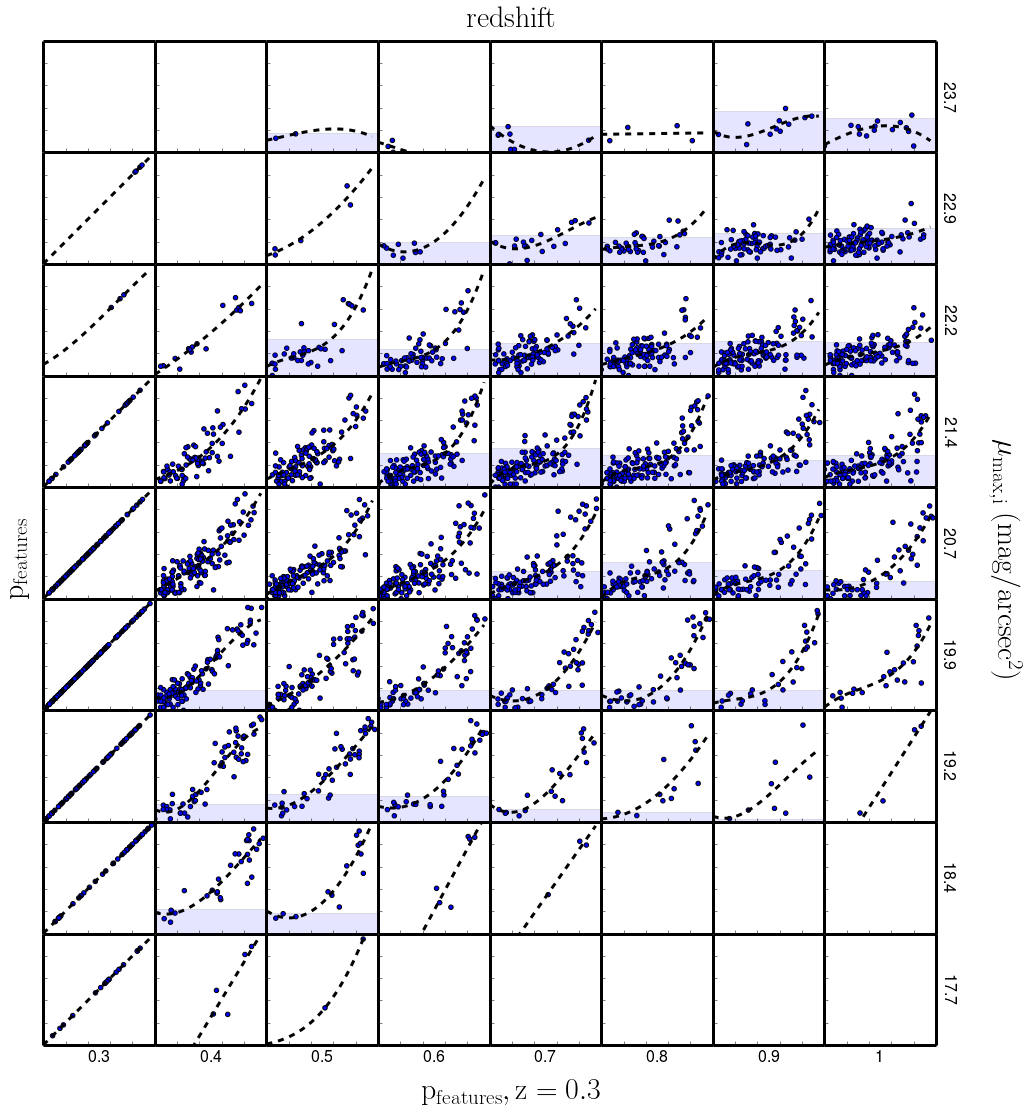

In [172]:
#Plot p_features at a given redshift vs p_features at z=0.3 at each redshift, binned by surface brightness
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,1))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        xs=scatter_dct[z,yedges[y],'lo']
        ys=scatter_dct[z,yedges[y],'hi']
        flat_list=[]
        p_range_uncorrectable_dct[z,yedges[y]]=[]
        p_range_correctable_dct[z,yedges[y]]=[]

        if len(xs)>1:
            poly_params=np.polynomial.polynomial.polyfit(xs,ys,3)
            poly = np.polynomial.Polynomial(poly_params)
            drv=derivative_of_poly(x_new,poly_params,3)
            if np.min(drv)>-1: #fit okay, go ahead and plot
                plt.scatter(xs,ys)
                plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
                for d,val in enumerate(drv):
                    if val < slope_cut:
                        #plt.axvline(x_new[d],lw=3,alpha=.1) #shade vertically 
                        flat_list.append(x_new[d]) #list of x-values for shaded region
                if len(flat_list)>0: # if there are bad regions, record stuff:
                    min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                    max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                    #get list of y values in shaded region
                    bad_p_at_z_list=[] 
                    for p_int,p in enumerate(xs): 
                        if p>=min_p_at_3 and p < max_p_at_3:
                            bad_p_at_z_list.append(ys[p_int])
                    #shade out 3 standard deviations above and below the mean of that area        
                    #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                    min_val = 0 #I think the minimum should be 0...because... 
                    if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                        max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                    else:
                        max_val=0
                    plt.axhspan(0,max_val,alpha=.1)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                    p_range_correctable_dct[z,yedges[y]].append(max_val)
                    p_range_correctable_dct[z,yedges[y]].append(1)
                else: #if no bad regions, whole square is correctable.    
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                    p_range_correctable_dct[z,yedges[y]].append(0)
                    p_range_correctable_dct[z,yedges[y]].append(1)



            else: #if < 0, try 2nd order instead 
                poly_params=np.polynomial.polynomial.polyfit(xs,ys,2)
                poly = np.polynomial.Polynomial(poly_params)
                drv=derivative_of_poly(x_new,poly_params,2)
                if np.min(drv)>-1: #fit okay, go ahead and plot
                    plt.scatter(xs,ys)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
                    for d,val in enumerate(drv):
                        if val < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                            flat_list.append(x_new[d]) #list of x-values for shaded region
                    if len(flat_list)>0: # if there are bad regions, record stuff:
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=[] 
                        for p_int,p in enumerate(xs): 
                            if p>=min_p_at_3 and p < max_p_at_3:
                                bad_p_at_z_list.append(ys[p_int])
                        #shade out 3 standard deviations around the mean of that area        
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                else: #fit still bad, do a linear
                    plt.scatter(xs,ys)
                    poly_params=np.polynomial.polynomial.polyfit(xs,ys,1)
                    poly = np.polynomial.Polynomial(poly_params)
                    drv=derivative_of_poly(x_new,poly_params,1)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                    p_range_correctable_dct[z,yedges[y]].append(0)
                    p_range_correctable_dct[z,yedges[y]].append(1)


            plt.xlim(0,1)
            plt.ylim(0,1)
   
        else: #no data in square, so nei    
            p_range_uncorrectable_dct[z,yedges[y]].append(0)
            p_range_uncorrectable_dct[z,yedges[y]].append(0) 
            p_range_correctable_dct[z,yedges[y]].append(0)
            p_range_correctable_dct[z,yedges[y]].append(0)
        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%y_label[j],fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3}$',fontsize=30,ha='center');

plt.savefig('/home/mel/Documents/GZ_HUBBLE/ferengi_debias/finding_matches/images/p_vs_p_SB_redshift_slope_method.pdf')

In [ ]:
#correctable range: white region 
#uncorrectable range: blue region
#NEI region: pink (or not on plot) 

In [167]:
#get list of debiasable ferengi galaxies 
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < 0.301:
        z0ind[ind] = True
        
data_z0 = data[z0ind]
category_list_ferengi=[]
for row in data_z0:
    if row['mu_max_i'] > yedges[0] and row['mu_max_i'] <= yedges[len(yedges)-1] and  row['sim_redshift'] > reds[0]-.05 and row['sim_redshift'] <= reds[len(reds)-1] + .05: # if within ferengi space, check where it is. else, consider NEI or uncorrectable.
        for y in range(0,len(yedges)-1):
            if row['mu_max_i'] > yedges[y] and row['mu_max_i'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['sim_redshift'] > reds[i]-.05 and row['sim_redshift'] <= reds[i] + .05: # pick out where it is in SB/z and check color
                        if row['p_features'] > p_range_correctable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_correctable_dct[z,yedges[y]][1]:# if it's in correctable range::
                            category_list_ferengi.append({'sdss_id':row['sdss_id'],'subject_id':row['subject_id'],'Correctable_Category':'correctable','sim_redshift':row['sim_redshift'],'p_features':row['p_features'],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
                        elif row['p_features'] > p_range_uncorrectable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_uncorrectable_dct[z,yedges[y]][1]:# if it's in uncorrectable range::
                            category_list_ferengi.append({'sdss_id':row['sdss_id'],'subject_id':row['subject_id'],'Correctable_Category':'uncorrectable','sim_redshift':row['sim_redshift'],'p_features':row['p_features'],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
                        else: #not in correctable or uncorrectable range, so nei
                            category_list_ferengi.append({'sdss_id':row['sdss_id'],'subject_id':row['subject_id'],'Correctable_Category':'nei','sim_redshift':row['sim_redshift'],'p_features':row['p_features'],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
    else: #galaxies outside ferengi SB and z limits - still need to have meaasureable z and SB to possibly correct. 
        if row['sim_redshift'] > 0 and row['sim_redshift'] < 9 and row['mu_max_i'] >0: #these have measurements for z and SB, put in NEI
                            category_list_ferengi.append({'sdss_id':row['sdss_id'],'subject_id':row['subject_id'],'Correctable_Category':'nei','sim_redshift':row['sim_redshift'],'p_features':row['p_features'],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})
        else: #these have nan or infinite values of z or mu, put in need_redshift_list
                            category_list_ferengi.append({'sdss_id':row['sdss_id'],'subject_id':row['subject_id'],'Correctable_Category':'nei_needs_redshift','sim_redshift':row['sim_redshift'],'p_features':row['p_features'],'sim_evolution':row['sim_evolution'],'mu_max_i':row['mu_max_i']})


In [168]:
#create fits file of galaxies with Correctable_Category Label for FERENGI
c0 = Column([x['sdss_id'] for x in category_list_ferengi], name='sdss_id', format='A24') 
c00 = Column([x['subject_id'] for x in category_list_ferengi], name='subject_id', format='A24') 
c01 = Column([x['Correctable_Category'] for x in category_list_ferengi], name='Correctable_Category',format='A24')
c02 = Column([x['p_features'] for x in category_list_ferengi], name='p_features',format='D')
c03 = Column([x['sim_redshift'] for x in category_list_ferengi], name='sim_redshift',format='D')
c04 = Column([x['sim_evolution'] for x in category_list_ferengi], name='sim_evolution',format='D')
c05 = Column([x['mu_max_i'] for x in category_list_ferengi], name='mu_max_i',format='D')

category_table_ferengi = Table()  
category_table_ferengi.add_columns([c0,c00,c01,c02,c03,c04,c05])

fname = 'ferengi_data_with_categories_slope_method_no_ev0.fits'
if os.path.exists(fname):
    os.remove(fname)
category_table_ferengi.write(fname,format='fits')

In [ ]:
hubble_data=fits.getdata('../data/Hubble_t01_data.fits',1)

In [ ]:
#determine which parts of hubble sample are correctable (white), uncorrectable (green), or nei (purple) 

category_list=[]
for row in hubble_data:
    if row['MU_HI'] > yedges[0] and row['MU_HI'] <= yedges[len(yedges)-1] and  row['Z'] > reds[0] and row['Z'] <= reds[len(reds)-1] + .05: # if within ferengi space, check where it is. else, consider NEI or uncorrectable.
        for y in range(0,len(yedges)-1):
            if row['MU_HI'] > yedges[y] and row['MU_HI'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['Z'] > reds[i]-.05 and row['Z'] <= reds[i] + .05: # pick out where it is in SB/z and check color
                        if row['p_features'] > p_range_correctable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_correctable_dct[z,yedges[y]][1]:# if it's in correctable range::
                            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'correctable','Imaging':row['Imaging']})
                        elif row['p_features'] > p_range_uncorrectable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_uncorrectable_dct[z,yedges[y]][1]:# if it's in uncorrectable range::
                            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'uncorrectable','Imaging':row['Imaging']})
                        else: #not in correctable or uncorrectable range, so nei
                            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'nei','Imaging':row['Imaging']})
    else: #galaxies outside ferengi SB and z limits - still need to have meaasureable z and SB to possibly correct. 
        if row['Z'] >=.3 and row['Z'] < 9 and row['MU_HI'] >0: #these have measurements for z and SB, put in NEI
            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'nei','Imaging':row['Imaging']})
        elif row['Z'] > 0 and row['Z'] < .3: #don't need to be corrected, z < z0
            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'z_lt_3','Imaging':row['Imaging']})
        else: #these have nan or infinite values of z or mu, put in need_redshift_list
            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'nei_needs_redshift','Imaging':row['Imaging']})

In [ ]:
low_hi_limit_list=[]
for row in hubble_data:
    if row['MU_HI'] > yedges[0] and row['MU_HI'] <= yedges[len(yedges)-1] and  row['Z'] > reds[0]-.05 and row['Z'] <= reds[len(reds)-1] + .05: 
        for y in range(0,len(yedges)-1):
            if row['MU_HI'] > yedges[y] and row['MU_HI'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['Z'] > reds[i]-.05 and row['Z'] <= reds[i] + .05: #now we have mu,z info:
                        for bin_range in interval_dct[z,yedges[y]]:
                            if row['p_features'] >= bin_range['bin_bottom'] and row['p_features'] < bin_range['bin_top']:
                                low_hi_limit_list.append({'objid':row['OBJNO'],'low_limit':bin_range['low_limit'],'hi_limit':bin_range['hi_limit']})
                        


In [ ]:
imaging_list=set(hubble_data['Imaging'])
total_correctable=0
total_uncorrectable=0
total_z_lt_3=0
total_nei=0
total_nr=0
for survey in imaging_list:
    c=0
    u=0
    z_lt_3=0
    nei=0
    nr=0
    for row in category_list:
        if row['Correctable_Category']=='correctable' and row['Imaging']==survey:
            c+=1
        if row['Correctable_Category']=='uncorrectable' and row['Imaging']==survey:
            u+=1
        if row['Correctable_Category']=='z_lt_3' and row['Imaging']==survey:
            z_lt_3+=1
        if row['Correctable_Category']=='nei' and row['Imaging']==survey:
            nei+=1
        if row['Correctable_Category']=='nei_needs_redshift' and row['Imaging']==survey:
            nr+=1
    total_correctable+=c
    total_uncorrectable+=u
    total_z_lt_3+=z_lt_3
    total_nei+=nei
    total_nr+=nr
    print 'the number of correctable galaxies in %s is %i' %(survey,c)
    print 'the number of uncorrectable galaxies in %s is %i' %(survey,u)
    print 'the number of galaxies with z < 0.3 in %s is %i' %(survey,z_lt_3)
    print 'the number of NEI galaxies in %s is (due to not enough Ferengi galaxies in bin) is %i' %(survey,nei)
    print 'the number of NEI galaxies in %s is (due to needing redshift measurements) is %i' %(survey,nr)
print 'total correctable: %i' %total_correctable
print 'total uncorrectable: %i' %total_uncorrectable
print 'total z less than .3: %i' %total_z_lt_3
print 'total nei: %i' %total_nei
print 'total nr: %i' %total_nr
print 'total: %i' %len(category_list)

In [ ]:
#create fits file of galaxies with Correctable_Category Label 
c0 = Column([x['objid'] for x in category_list], name='objid') 
c01 = Column([x['Correctable_Category'] for x in category_list], name='Correctable_Category')
category_table = Table()  
category_table.add_columns([c0,c01])

fname = 'category_table.fits'
if os.path.exists(fname):
    os.remove(fname)
category_table.write(fname,format='fits')

In [ ]:
#create fits file of lower and upper limits for p_features
c2 = Column([x['objid'] for x in low_hi_limit_list], name='objid') 
c3 = Column([x['low_limit'] for x in low_hi_limit_list], name='low_limit') 
c4 = Column([x['hi_limit'] for x in low_hi_limit_list], name='hi_limit') 
limit_table = Table()  
limit_table.add_columns([c2,c3,c4])

fname = 'limits_table.fits'
if os.path.exists(fname):
    os.remove(fname)
limit_table.write(fname,format='fits')

In [27]:
xs=scatter_dct[.3,yedges[7],'lo']
ys=scatter_dct[.3,yedges[7],'hi']


In [ ]:
plt.scatter(xs,ys)
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
            poly = calculate_hbins(vbins,3)
            if poly(vbins)[1] < poly(vbins)[0]:#bump in curve, bin edges out of order. No! 
                poly = calculate_hbins(vbins,2)#redo with 2nd degree polynomial 
                plot_hbins(poly)


In [ ]:
plt.savefig('/home/mel/Documents/GZ_HUBBLE/ferengi_debias/finding_matches/images/p_vs_p_SB_redshift_no_0_evolutions.pdf')

In [101]:
xs=scatter_dct[.7,yedges[4],'lo']
ys=scatter_dct[.7,yedges[4],'hi']
poly_params=np.polynomial.polynomial.polyfit(xs,ys,3)
poly = np.polynomial.Polynomial(poly_params)

(0, 1.1)

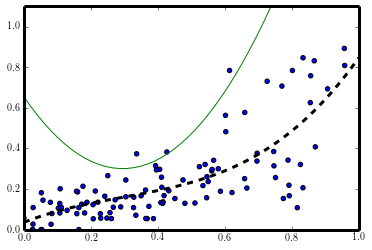

In [102]:
plt.scatter(xs,ys)
x_new = np.linspace(0,1,50)

plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')

drv=derivative_of_poly(x_new,poly_params,3)
plt.plot(x_new,drv)
plt.xlim(0,1)
plt.ylim(0,1.1)

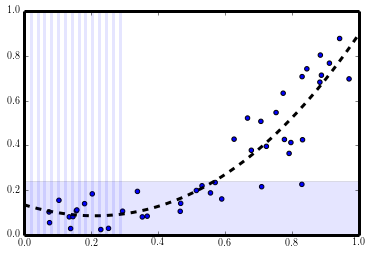

In [127]:
xs=scatter_dct[.7,yedges[3],'lo']
ys=scatter_dct[.7,yedges[3],'hi']
        
if len(xs)>0:
    poly_params=np.polynomial.polynomial.polyfit(xs,ys,3)
    poly = np.polynomial.Polynomial(poly_params)
    drv=derivative_of_poly(x_new,poly_params,3)
    if np.min(drv)>-1: #fit okay, go ahead and plot
        plt.scatter(xs,ys)
        plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='k',lw=3,ls='dashed')
        flat_list=[]
        for d,val in enumerate(drv):
            if val < .2:
                plt.axvline(x_new[d],lw=3,alpha=.1)
                flat_list.append(x_new[d])
        plt.axhspan(min_val,max_val,alpha=.1)
    plt.xlim(0,1)
    plt.ylim(0,1)


In [119]:
min_p_at_3=np.min(flat_list)
max_p_at_3=np.max(flat_list)
bad_p_at_z_list=[]

In [120]:
for p_int,p in enumerate(xs):
    if p>=min_p_at_3 and p < max_p_at_3:
        bad_p_at_z_list.append(ys[p_int])

In [160]:
p_range_uncorrectable_dct

{(0.3, 17.284900665283203): [0, 0],
 (0.3, 18.035033967759873): [0, 0],
 (0.3, 18.785167270236546): [0, 0],
 (0.3, 19.535300572713215): [0, 0],
 (0.3, 20.285433875189888): [0, 0],
 (0.3, 21.035567177666557): [0, 0],
 (0.3, 21.785700480143227): [0, 0],
 (0.3, 22.5358337826199): [0, 0],
 (0.3, 23.285967085096573): [0, 0],
 (0.4, 17.284900665283203): [0, 0],
 (0.4, 18.035033967759873): [0, 0.2243267030674361],
 (0.4, 18.785167270236546): [0, 0.17136332548113004],
 (0.4, 19.535300572713215): [0, 0.17764727787993778],
 (0.4, 20.285433875189888): [0, 0],
 (0.4, 21.035567177666557): [0, 0],
 (0.4, 21.785700480143227): [0, 0],
 (0.4, 22.5358337826199): [0, 0],
 (0.4, 23.285967085096573): [0, 0],
 (0.5, 17.284900665283203): [0, 0],
 (0.5, 18.035033967759873): [0, 0.18023106842330033],
 (0.5, 18.785167270236546): [0, 0.15104771902912212],
 (0.5, 19.535300572713215): [0, 0],
 (0.5, 20.285433875189888): [0, 0],
 (0.5, 21.035567177666557): [0, 0],
 (0.5, 21.785700480143227): [0, 0],
 (0.5, 22.53583

In [124]:
3*np.std(bad_p_at_z_list)

0.14914951651715788

In [125]:
min_val = np.mean(bad_p_at_z_list)-3*np.std(bad_p_at_z_list)
max_val = np.mean(bad_p_at_z_list)+3*np.std(bad_p_at_z_list)


In [139]:
this_list=[1]

In [141]:
np.std(this_list)

0.0